# Intelligent Tagging and Recommendation System for StackOverflow Posts
### APAN 5430: Applied Text & Natural Language Analytics Term Project
#### Group 3
#### Group Members: Sixuan Li, Wenyang Cao, Haoran Yang, Wenling Zhou, Jake Xiao
#### Github Repo: [https://github.com/educated-fool/stack-overflow-intelligent-tagging](https://github.com/educated-fool/stack-overflow-intelligent-tagging)

## Load required Packages 

In [1]:
import os
import pandas as pd
import numpy as np
import joblib
import time
from tqdm import tqdm
tqdm.pandas()
from collections import Counter
from bs4 import BeautifulSoup
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
import xgboost as xgb
from IPython.display import display

## Load Checkpoint

In this section, we save the current state of the dataframe to a pickle file and then reload it. This allows us to easily return to this point in our data processing pipeline without having to re-run all previous steps.

In [14]:
df = pd.read_pickle("/Users/yanghaoran/Desktop/APAN 5430 NLA/5430 NLP Project/2Data/cp_1.pkl")  # load the preprocessed data

## Reduce Data Size for Efficient Processing

The following code snippet demonstrates how to reduce the size of the dataset for efficient processing. The dataset is first shuffled to ensure randomness, and then a subset of 250,000 records is selected for further analysis.

In [6]:
# Reduce data size
df = shuffle(df, random_state=42)
df = df[:250000]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250000 entries, 487584 to 299596
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               250000 non-null  int64 
 1   title            250000 non-null  object
 2   body             250000 non-null  object
 3   tags             250000 non-null  object
 4   tag_count        250000 non-null  int64 
 5   body_tokenized   250000 non-null  object
 6   title_tokenized  250000 non-null  object
dtypes: int64(2), object(5)
memory usage: 15.3+ MB


In [11]:
from collections import Counter

tag_count = Counter()

def count_tag(tags):
    for tag in tags:
        tag_count[tag] += 1

df["tags"].apply(count_tag)

len(tag_count.values())

25135

In [15]:
most_common_tags = [count[0] for count in tag_count.most_common(100)]
df["tags"] = df["tags"].progress_apply(lambda tags: [tag for tag in tags if tag in most_common_tags])

100%|██████████| 250000/250000 [00:00<00:00, 384466.83it/s]


In [16]:
df[df["tags"].map(lambda tags: len(tags) > 0)].shape

(208984, 7)

In [17]:
df = df[df["tags"].map(lambda tags: len(tags) > 0)]

In [18]:
df.isnull().sum()

id                 0
title              0
body               0
tags               0
tag_count          0
body_tokenized     0
title_tokenized    0
dtype: int64

In [19]:
# Ensure all tags are strings and handle NaN values
df['tags'] = df['tags'].apply(lambda x: [str(tag) for tag in x if pd.notna(tag)])

In [20]:
df.sample(5)

,id,title,body,tags,tag_count,body_tokenized,title_tokenized
14847,875760,run code on creation of a php class instance?,i want code to run whenever i create a new obj...,"[php, class]",3,"[want, code, run, whenever, create, new, objec...","[run, code, creation, php, class, instance]"
800908,27022410,is the rest api active in italy for direct pay...,i just wanted to know if i can use the rest ap...,"[api, rest]",4,"[wanted, know, use, rest, api, direct, payment...","[rest, api, active, italy, direct, payment, cr..."
743931,25238600,how to add many module dependencies in angularjs,if i want to add both ['textangular'] and ['ng...,[angularjs],1,"[want, add, app, iv, e, tried, work, var, app]","[add, many, module, dependencies, angularjs]"
94174,3983490,"document.getelementbyid('box').style.width=""10...",i cannot seem to get this script to work. can ...,"[javascript, css]",2,"[seem, get, script, work, anyone, please, help...",[work]
274441,10084510,socket receiving no data. why?,i was learning socket programming and tried to...,"[python, sockets]",3,"[learning, socket, programming, tried, design,...","[socket, receiving, data]"


In [21]:
df['text'] = df['title_tokenized'].progress_apply(' '.join)

100%|██████████| 208984/208984 [00:00<00:00, 244881.40it/s]


## Prepare Features and Labels

This section demonstrates how to prepare the features and labels for a multi-label classification task, binarize the tags, split the data into training and test sets, save the datasets, and convert text data into TF-IDF features.

In [22]:
# Prepare features and labels
X = df['text']
y = df['tags']

# Binarize the tags for multi-label classification
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
joblib.dump(X_train, '/Users/yanghaoran/Desktop/APAN 5430 NLA/5430 NLP Project/2Data/X_train.pkl')
joblib.dump(X_test, '/Users/yanghaoran/Desktop/APAN 5430 NLA/5430 NLP Project/2Data/X_test.pkl')
joblib.dump(y_train, '/Users/yanghaoran/Desktop/APAN 5430 NLA/5430 NLP Project/2Data/y_train.pkl')
joblib.dump(y_test, '/Users/yanghaoran/Desktop/APAN 5430 NLA/5430 NLP Project/2Data/y_test.pkl')

['/Users/yanghaoran/Desktop/APAN 5430 NLA/5430 NLP Project/2Data/y_test.pkl']

In [2]:
# Load the datasets
X_train = joblib.load('/Users/yanghaoran/Desktop/APAN 5430 NLA/5430 NLP Project/2Data/X_train.pkl')
X_test = joblib.load('/Users/yanghaoran/Desktop/APAN 5430 NLA/5430 NLP Project/2Data/X_test.pkl')
y_train = joblib.load('/Users/yanghaoran/Desktop/APAN 5430 NLA/5430 NLP Project/2Data/y_train.pkl')
y_test = joblib.load('/Users/yanghaoran/Desktop/APAN 5430 NLA/5430 NLP Project/2Data/y_test.pkl')

print("Data loaded successfully!")

Data loaded successfully!


In [5]:
# Convert text data into TF-IDF features
vectorizer = TfidfVectorizer(max_features=10000)  # Limiting to 10,000 features
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## SGD Model Training (Version 1)

In this section, we train an SGDClassifier model for multi-label classification using the OneVsRestClassifier wrapper. The key steps are:

1. **Build the Model**: We initialize the model with `max_iter=1000` and `tol=1e-3`, setting the maximum number of iterations and the tolerance for convergence.

2. **Custom Training Loop**: We implement a custom training loop running for 100 epochs. Using the `tqdm` library, we add a progress bar to visualize the training progress. In each epoch, the model is fit on the training TF-IDF features and labels.

This is the first version of our SGD model, providing a baseline for further optimization and evaluation.


In [81]:
# Build the model
model = OneVsRestClassifier(SGDClassifier(max_iter=1000, tol=1e-3))

In [75]:
# Custom training loop with progress bar
n_epochs = 100
for epoch in tqdm(range(n_epochs), desc="Training Progress"):
    model.fit(X_train_tfidf, y_train)

Training Progress: 100%|██████████| 100/100 [16:34<00:00,  9.94s/it]


In [76]:
# Predict and evaluate the model
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=mlb.classes_)

/Users/yanghaoran/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yanghaoran/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [77]:
y_train_pred = model.predict(X_train_tfidf)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_accuracy

0.2112066129543565

In [78]:
# Print the evaluation results
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.20970404574490992
Classification Report:
                    precision    recall  f1-score   support

         .htaccess       0.96      0.27      0.43       190
              .net       0.62      0.02      0.03       914
              ajax       0.82      0.54      0.65       592
         algorithm       0.68      0.21      0.32       278
           android       0.96      0.54      0.69      3588
         angularjs       0.97      0.60      0.74       799
            apache       0.70      0.29      0.41       251
               api       0.00      0.00      0.00       202
            arrays       0.61      0.12      0.20       749
           asp.net       0.85      0.29      0.44      1143
       asp.net-mvc       0.77      0.38      0.51       528
              bash       0.93      0.38      0.54       299
                 c       0.00      0.00      0.00       940
                c#       0.71      0.04      0.07      3834
               c++       0.92      0.07      0

In [190]:
# Convert y_test and y_pred to NumPy arrays for proper formatting
y_test_np = np.array(y_test)
y_pred_np = np.array(y_pred)

# Examples
n_examples = 20
for i in range(n_examples):
    print('Question: ', X_test.iloc[i])
    print('Actual Tags: ', mlb.inverse_transform(y_test_np[i].reshape(1, -1))[0])
    print('Predicted Tags: ', mlb.inverse_transform(y_pred_np[i].reshape(1, -1))[0])
    print('\n')

Question:  compare two strings system call
Actual Tags:  ('c', 'string')
Predicted Tags:  ()


Question:  class library present notification
Actual Tags:  ('.net',)
Predicted Tags:  ()


Question:  add customer address stripe rails app monospace
Actual Tags:  ('ruby', 'ruby-on-rails')
Predicted Tags:  ('ruby-on-rails',)


Question:  lock tables work expected browser
Actual Tags:  ('database', 'mysql')
Predicted Tags:  ()


Question:  getting scrollbar bottom loading page ajax jquery
Actual Tags:  ('ajax', 'jquery')
Predicted Tags:  ('ajax', 'jquery')


Question:  save removed string new string
Actual Tags:  ('javascript', 'regex', 'string')
Predicted Tags:  ()


Question:  method async
Actual Tags:  ('c#', 'multithreading')
Predicted Tags:  ()


Question:  right click touch screen device
Actual Tags:  ('jquery',)
Predicted Tags:  ()


Question:  list available callbacks exposed flash element
Actual Tags:  ('javascript',)
Predicted Tags:  ()


Question:  organize array table view alphab

## SGD Model Training (Version 2)

We introduce the following changes and enhancements:

1. **Increased Feature Count and N-grams**: The TF-IDF vectorizer is configured to use a maximum of 20,000 features and include bigrams, capturing more detailed information from the text.
2. **Randomized Search for Hyperparameters**: We perform a RandomizedSearchCV with 20 iterations to find the best hyperparameters for the SGDClassifier. The parameters include:
   - `alpha`: [1e-4, 1e-3, 1e-2, 1e-1] - Regularization strength.
   - `loss`: ['hinge', 'log', 'modified_huber'] - Loss functions.
   - `penalty`: ['l2', 'l1', 'elasticnet'] - Regularization penalties.
   - `learning_rate`: ['optimal', 'constant', 'adaptive'] - Learning rate schedules.
   - `max_iter`: [500, 1000] - Maximum number of iterations.
3. **Model Training and Evaluation**: Using the best parameters found, the model is trained on the TF-IDF features. We evaluate the model's performance using accuracy, F1 score, precision, and recall for both training and test sets.

This version introduces hyperparameter optimization to improve the model's performance over the initial version.


In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
import joblib
import numpy as np


# Prepare features and labels
X = df['text']
y = df['tags']

# Binarize the tags for multi-label classification
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text data into TF-IDF features
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1, 2))  # Increase feature count and use n-gram
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Initialize and optimize the model
param_dist = {
    'estimator__alpha': [1e-4, 1e-3, 1e-2, 1e-1],
    'estimator__loss': ['hinge', 'log', 'modified_huber'],
    'estimator__penalty': ['l2', 'l1', 'elasticnet'],
    'estimator__learning_rate': ['optimal', 'constant', 'adaptive'],
    'estimator__max_iter': [500, 1000]
}

sgd_clf = SGDClassifier()
model = OneVsRestClassifier(sgd_clf)

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=20, cv=2, verbose=3, n_jobs=-1, random_state=42)
random_search.fit(X_train_tfidf, y_train)

print("Best parameters found: ", random_search.best_params_)

# Use the best model for prediction and evaluation
best_model = random_search.best_estimator_
y_train_pred = best_model.predict(X_train_tfidf)
y_test_pred = best_model.predict(X_test_tfidf)

# Calculate and print evaluation metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_f1 = f1_score(y_train, y_train_pred, average='micro')
test_f1 = f1_score(y_test, y_test_pred, average='micro')
train_precision = precision_score(y_train, y_train_pred, average='micro')
test_precision = precision_score(y_test, y_test_pred, average='micro')
train_recall = recall_score(y_train, y_train_pred, average='micro')
test_recall = recall_score(y_test, y_test_pred, average='micro')

print(f'Training Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Training F1 Score: {train_f1}')
print(f'Test F1 Score: {test_f1}')
print(f'Training Precision: {train_precision}')
print(f'Test Precision: {test_precision}')
print(f'Training Recall: {train_recall}')
print(f'Test Recall: {test_recall}')

# Print classification report
report = classification_report(y_test, y_test_pred, target_names=mlb.classes_)
print('Classification Report:')
print(report)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV 1/2] END estimator__alpha=0.1, estimator__learning_rate=adaptive, estimator__loss=hinge, estimator__max_iter=1000, estimator__penalty=l2;, score=nan total time=   2.2s
[CV 1/2] END estimator__alpha=0.01, estimator__learning_rate=constant, estimator__loss=modified_huber, estimator__max_iter=500, estimator__penalty=l2;, score=nan total time=   2.3s
[CV 2/2] END estimator__alpha=0.1, estimator__learning_rate=adaptive, estimator__loss=modified_huber, estimator__max_iter=1000, estimator__penalty=l2;, score=nan total time=   2.4s
[CV 2/2] END estimator__alpha=0.1, estimator__learning_rate=adaptive, estimator__loss=hinge, estimator__max_iter=1000, estimator__penalty=l2;, score=nan total time=   2.4s
[CV 1/2] END estimator__alpha=0.1, estimator__learning_rate=adaptive, estimator__loss=modified_huber, estimator__max_iter=1000, estimator__penalty=l2;, score=nan total time=   2.5s
[CV 2/2] END estimator__alpha=0.01, estimator__learn

/Users/yanghaoran/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
28 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/yanghaoran/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/yanghaoran/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/yanghaoran/anaconda3/lib/python3.11/site-packages/sklearn/mult

Best parameters found:  {'estimator__penalty': 'l2', 'estimator__max_iter': 1000, 'estimator__loss': 'modified_huber', 'estimator__learning_rate': 'optimal', 'estimator__alpha': 0.0001}
Training Accuracy: 0.2483506492729698
Test Accuracy: 0.23511256788764745
Training F1 Score: 0.5082531583315403
Test F1 Score: 0.4940434764809432
Training Precision: 0.8783221488393506
Test Precision: 0.8582604366688003
Training Recall: 0.3575882526798394
Test Recall: 0.34685137815077743
Classification Report:
                    precision    recall  f1-score   support

         .htaccess       0.91      0.31      0.46       222
              .net       0.71      0.08      0.14       915
              ajax       0.80      0.51      0.62       599
         algorithm       0.75      0.20      0.31       281
           android       0.97      0.60      0.74      3533
         angularjs       0.96      0.56      0.71       768
            apache       0.79      0.24      0.37       273
               api    

/Users/yanghaoran/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yanghaoran/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
report = classification_report(y_test, y_test_pred, target_names=mlb.classes_, output_dict=True)

##  SGD Model Training (Version 3)

In this section, we further optimize the SGDClassifier model for multi-label classification using the OneVsRestClassifier wrapper, incorporating additional enhancements and parameter tuning. The key steps include:

1. **Increased Feature Count and N-grams**: The TF-IDF vectorizer is configured to use a maximum of 25,000 features and include bigrams, which helps capture more detailed information from the text data.
2. **Randomized Search for Hyperparameters**: We perform a more comprehensive RandomizedSearchCV with 25 iterations to find the optimal hyperparameters for the SGDClassifier. The parameters we optimize include:
   - `alpha`: [1e-4, 1e-3, 1e-2, 1e-1] - Regularization strength.
   - `loss`: ['hinge', 'log', 'modified_huber'] - Different loss functions.
   - `penalty`: ['l2', 'l1', 'elasticnet'] - Regularization penalties.
   - `learning_rate`: ['optimal', 'constant', 'adaptive'] - Learning rate schedules.
   - `max_iter`: [500, 1000, 1500] - Maximum number of iterations.
3. **Model Training and Evaluation**: Using the best parameters found from the random search, the model is trained on the TF-IDF features. The model's performance is evaluated using accuracy, F1 score, precision, and recall for both the training and test sets. A detailed classification report is also generated to provide insights into the model's performance.

This version of the SGD model incorporates a more extensive hyperparameter tuning process and an increased feature set, aimed at achieving better performance and capturing more complex patterns in the data.


In [89]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
import joblib
import numpy as np


# Prepare features and labels
X = df['text']
y = df['tags']

# Binarize the tags for multi-label classification
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text data into TF-IDF features
vectorizer = TfidfVectorizer(max_features=25000, ngram_range=(1, 2))  # Increase feature count and use n-gram
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Initialize and optimize the model
param_dist = {
    'estimator__alpha': [1e-4, 1e-3, 1e-2, 1e-1],
    'estimator__loss': ['hinge', 'log', 'modified_huber'],
    'estimator__penalty': ['l2', 'l1', 'elasticnet'],
    'estimator__learning_rate': ['optimal', 'constant', 'adaptive'],
    'estimator__max_iter': [500, 1000, 1500]
}

sgd_clf = SGDClassifier()
model = OneVsRestClassifier(sgd_clf)

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=25, cv=3, verbose=3, n_jobs=-1, random_state=42)
random_search.fit(X_train_tfidf, y_train)

print("Best parameters found: ", random_search.best_params_)

# Use the best model for prediction and evaluation
best_model = random_search.best_estimator_
y_train_pred = best_model.predict(X_train_tfidf)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Training Accuracy: {train_accuracy}')

y_test_pred = best_model.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy}')

report = classification_report(y_test, y_test_pred, target_names=mlb.classes_)
print('Classification Report:')
print(report)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV 2/3] END estimator__alpha=0.001, estimator__learning_rate=constant, estimator__loss=modified_huber, estimator__max_iter=1500, estimator__penalty=l2;, score=nan total time=   5.2s
[CV 2/3] END estimator__alpha=0.001, estimator__learning_rate=adaptive, estimator__loss=hinge, estimator__max_iter=500, estimator__penalty=elasticnet;, score=nan total time=   5.9s
[CV 3/3] END estimator__alpha=0.001, estimator__learning_rate=constant, estimator__loss=hinge, estimator__max_iter=500, estimator__penalty=l2;, score=nan total time=   6.3s
[CV 1/3] END estimator__alpha=0.001, estimator__learning_rate=constant, estimator__loss=hinge, estimator__max_iter=500, estimator__penalty=l2;, score=nan total time=   6.4s
[CV 3/3] END estimator__alpha=0.001, estimator__learning_rate=constant, estimator__loss=modified_huber, estimator__max_iter=1500, estimator__penalty=l2;, score=nan total time=   6.4s
[CV 1/3] END estimator__alpha=0.001, estimator

/Users/yanghaoran/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
54 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
33 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/yanghaoran/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/yanghaoran/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/yanghaoran/anaconda3/lib/python3.11/site-packages/sklearn/mult

Best parameters found:  {'estimator__penalty': 'l1', 'estimator__max_iter': 1500, 'estimator__loss': 'modified_huber', 'estimator__learning_rate': 'optimal', 'estimator__alpha': 0.0001}
Training Accuracy: 0.23602911709642496
Test Accuracy: 0.23106921549393497
Classification Report:
                    precision    recall  f1-score   support

         .htaccess       0.91      0.31      0.46       190
              .net       0.59      0.11      0.18       914
              ajax       0.82      0.53      0.64       592
         algorithm       0.67      0.21      0.31       278
           android       0.94      0.60      0.73      3588
         angularjs       0.96      0.61      0.75       799
            apache       0.71      0.28      0.40       251
               api       0.18      0.01      0.02       202
            arrays       0.51      0.28      0.36       749
           asp.net       0.82      0.31      0.45      1143
       asp.net-mvc       0.74      0.32      0.45       

/Users/yanghaoran/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yanghaoran/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## XGBoost Model Training (Version 1)
The XGBoost classifier is initialized with 100 estimators, a learning rate of 0.1, and a maximum depth of 3. We measure the training time and evaluate the model's performance using accuracy and a detailed classification report. This version serves as our initial implementation, providing a baseline for further optimization.














In [93]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.multiclass import OneVsRestClassifier
import xgboost as xgb
import joblib
import time


X = df['text']
y = df['tags']

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=25000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, n_jobs=-1)
model = OneVsRestClassifier(xgb_clf)

start_time = time.time()
model.fit(X_train_tfidf, y_train)
end_time = time.time()

train_time = end_time - start_time

y_train_pred = model.predict(X_train_tfidf)
y_test_pred = model.predict(X_test_tfidf)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'XGBoost - Training Accuracy: {train_accuracy}')
print(f'XGBoost - Test Accuracy: {test_accuracy}')
print(f'XGBoost - Training Time (s): {train_time}')
print(f'XGBoost - Classification Report:')
print(classification_report(y_test, y_test_pred, target_names=mlb.classes_))

XGBoost - Training Accuracy: 0.22319319085814088
XGBoost - Test Accuracy: 0.21640309113094242
XGBoost - Training Time (s): 368.647912979126
XGBoost - Classification Report:


/Users/yanghaoran/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                    precision    recall  f1-score   support

         .htaccess       0.85      0.32      0.46       190
              .net       0.61      0.14      0.22       914
              ajax       0.83      0.54      0.66       592
         algorithm       0.67      0.22      0.34       278
           android       0.97      0.52      0.67      3588
         angularjs       0.97      0.61      0.75       799
            apache       0.73      0.27      0.40       251
               api       0.50      0.01      0.03       202
            arrays       0.54      0.33      0.41       749
           asp.net       0.86      0.29      0.44      1143
       asp.net-mvc       0.77      0.38      0.50       528
              bash       0.83      0.38      0.53       299
                 c       0.66      0.02      0.04       940
                c#       0.70      0.03      0.06      3834
               c++       0.95      0.09      0.16      1983
             class       0.00      0.00

/Users/yanghaoran/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## XGBoost Model Training (Version 2)
In this section, we train an XGBoost model for multi-label classification with a focus on improving performance by adjusting key parameters. 

We set the maximum depth to 5, which enhances accuracy but significantly increases training time.  

We initialize the XGBoost classifier with 100 estimators, a learning rate of 0.1, and a maximum depth of 5. The model's performance is evaluated using accuracy, F1 score, precision, and recall. This version demonstrates improved accuracy, though attempts to further increase parameters resulted in kernel crashes.







In [25]:
%%time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score
from sklearn.multiclass import OneVsRestClassifier
import xgboost as xgb
import joblib
import time

# Assuming df is already processed and contains 'text' and 'tags' columns

# Prepare features and labels
X = df['text']
y = df['tags']

# Binarize the tags for multi-label classification
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text data into TF-IDF features
vectorizer = TfidfVectorizer(max_features=25000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Initialize and train the XGBoost model
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, n_jobs=-1)
model = OneVsRestClassifier(xgb_clf)

# Measure training time
start_time = time.time()
model.fit(X_train_tfidf, y_train)
end_time = time.time()
train_time = end_time - start_time

# Predict and evaluate
y_train_pred = model.predict(X_train_tfidf)
y_test_pred = model.predict(X_test_tfidf)

# Calculate evaluation metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_f1 = f1_score(y_train, y_train_pred, average='micro')
test_f1 = f1_score(y_test, y_test_pred, average='micro')
train_precision = precision_score(y_train, y_train_pred, average='micro')
test_precision = precision_score(y_test, y_test_pred, average='micro')
train_recall = recall_score(y_train, y_train_pred, average='micro')
test_recall = recall_score(y_test, y_test_pred, average='micro')

print(f'XGBoost - Training Accuracy: {train_accuracy}')
print(f'XGBoost - Test Accuracy: {test_accuracy}')
print(f'XGBoost - Training Time (s): {train_time}')
print(f'XGBoost - Training F1 Score: {train_f1}')
print(f'XGBoost - Test F1 Score: {test_f1}')
print(f'XGBoost - Training Precision: {train_precision}')
print(f'XGBoost - Test Precision: {test_precision}')
print(f'XGBoost - Training Recall: {train_recall}')
print(f'XGBoost - Test Recall: {test_recall}')

# Print classification report
print(f'XGBoost - Classification Report:')
print(classification_report(y_test, y_test_pred, target_names=mlb.classes_))

XGBoost - Training Accuracy: 0.24425942208425297
XGBoost - Test Accuracy: 0.22047036868674785
XGBoost - Training Time (s): 741.9847559928894
XGBoost - Training F1 Score: 0.5040878445060825
XGBoost - Test F1 Score: 0.4792706930487931
XGBoost - Training Precision: 0.9019163212579692
XGBoost - Test Precision: 0.858521377672209
XGBoost - Training Recall: 0.3497956329611234
XGBoost - Test Recall: 0.332423188572414
XGBoost - Classification Report:
                    precision    recall  f1-score   support

         .htaccess       0.82      0.36      0.50       222
              .net       0.66      0.13      0.22       915
              ajax       0.80      0.51      0.62       599
         algorithm       0.73      0.21      0.32       281
           android       0.98      0.55      0.70      3533
         angularjs       0.94      0.58      0.72       768
            apache       0.70      0.27      0.39       273
               api       0.78      0.04      0.07       200
            a

/Users/yanghaoran/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yanghaoran/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## XGBoost Model Training (Version 3)
For this version, we increase the number of estimators to 150 and lower the learning rate to 0.05 while maintaining the maximum depth at 5. Additionally, we set the subsample and colsample_bytree parameters to 0.8 to help prevent overfitting. 

This version aims to balance model complexity and performance, with careful adjustments to improve accuracy while managing training time and preventing overfitting.







In [97]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.multiclass import OneVsRestClassifier
import xgboost as xgb
import joblib
import time

# Prepare features and labels
X = df['text']
y = df['tags']

# Binarize the tags for multi-label classification
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text data into TF-IDF features
vectorizer = TfidfVectorizer(max_features=25000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Initialize the XGBoost model
xgb_clf = xgb.XGBClassifier(n_estimators=150, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, n_jobs=-1)
model = OneVsRestClassifier(xgb_clf)

# Measure training time
start_time = time.time()
model.fit(X_train_tfidf, y_train)
end_time = time.time()
train_time = end_time - start_time

# Predict and evaluate
y_train_pred = model.predict(X_train_tfidf)
y_test_pred = model.predict(X_test_tfidf)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'XGBoost - Training Accuracy: {train_accuracy}')
print(f'XGBoost - Test Accuracy: {test_accuracy}')
print(f'XGBoost - Training Time (s): {train_time}')
print(f'XGBoost - Classification Report:')
print(classification_report(y_test, y_test_pred, target_names=mlb.classes_))

XGBoost - Training Accuracy: 0.23263770508472548
XGBoost - Test Accuracy: 0.21769504988396296
XGBoost - Training Time (s): 1131.0956649780273
XGBoost - Classification Report:
                    precision    recall  f1-score   support

         .htaccess       0.86      0.32      0.46       190
              .net       0.62      0.13      0.22       914
              ajax       0.83      0.54      0.65       592
         algorithm       0.67      0.22      0.33       278
           android       0.97      0.52      0.68      3588
         angularjs       0.97      0.61      0.75       799
            apache       0.73      0.28      0.41       251
               api       0.44      0.02      0.04       202
            arrays       0.55      0.37      0.44       749
           asp.net       0.86      0.31      0.46      1143
       asp.net-mvc       0.78      0.38      0.51       528
              bash       0.83      0.39      0.53       299
                 c       0.68      0.03     

/Users/yanghaoran/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yanghaoran/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Logistic Regression Model Training
In this section, we train a Logistic Regression model for multi-label classification using the OneVsRestClassifier wrapper. We initialize the model with a maximum of 1000 iterations and utilize all available CPU cores (`n_jobs=-1`). We measure the training time and fit the model on the training TF-IDF features and labels. After training, we predict on both the training and test datasets and calculate evaluation metrics such as accuracy, F1 score, precision, and recall. We then print these metrics along with a detailed classification report to assess the model's performance.







In [26]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the Logistic Regression model
lr_clf = LogisticRegression(max_iter=1000, n_jobs=-1)
model = OneVsRestClassifier(lr_clf)

# Measure training time
start_time = time.time()
model.fit(X_train_tfidf, y_train)
end_time = time.time()
train_time = end_time - start_time

# Predict and evaluate
y_train_pred = model.predict(X_train_tfidf)
y_test_pred = model.predict(X_test_tfidf)

# Calculate evaluation metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_f1 = f1_score(y_train, y_train_pred, average='micro')
test_f1 = f1_score(y_test, y_test_pred, average='micro')
train_precision = precision_score(y_train, y_train_pred, average='micro')
test_precision = precision_score(y_test, y_test_pred, average='micro')
train_recall = recall_score(y_train, y_train_pred, average='micro')
test_recall = recall_score(y_test, y_test_pred, average='micro')

print(f'Logistic Regression - Training Accuracy: {train_accuracy}')
print(f'Logistic Regression - Test Accuracy: {test_accuracy}')
print(f'Logistic Regression - Training Time (s): {train_time}')
print(f'Logistic Regression - Training F1 Score: {train_f1}')
print(f'Logistic Regression - Test F1 Score: {test_f1}')
print(f'Logistic Regression - Training Precision: {train_precision}')
print(f'Logistic Regression - Test Precision: {test_precision}')
print(f'Logistic Regression - Training Recall: {train_recall}')
print(f'Logistic Regression - Test Recall: {test_recall}')

# Print classification report
print(f'Logistic Regression - Classification Report:')
print(classification_report(y_test, y_test_pred, target_names=mlb.classes_))

Logistic Regression - Training Accuracy: 0.25902731671720886
Logistic Regression - Test Accuracy: 0.23587817307462258
Logistic Regression - Training Time (s): 140.41690373420715
Logistic Regression - Training F1 Score: 0.5259014791586694
Logistic Regression - Test F1 Score: 0.5008058899611979
Logistic Regression - Training Precision: 0.8525603724178062
Logistic Regression - Test Precision: 0.8138662527486742
Logistic Regression - Training Recall: 0.3802200099480252
Logistic Regression - Test Recall: 0.36168194751817895
Logistic Regression - Classification Report:
                    precision    recall  f1-score   support

         .htaccess       0.84      0.31      0.45       222
              .net       0.68      0.09      0.17       915
              ajax       0.81      0.46      0.59       599
         algorithm       0.82      0.19      0.31       281
           android       0.96      0.63      0.76      3533
         angularjs       0.95      0.55      0.70       768
         

/Users/yanghaoran/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Model Evaluation Summary 
In this section, we summarize the characteristics, key parameter changes, training times, performance metrics, issues encountered, and possible causes for three models: Logistic Regression, XGBoost, and SGDClassifier. This summary provides insights into the different approaches used, highlighting the adjustments made to each model, the resulting performance, and the challenges faced during training and evaluation.


In [1]:
import pandas as pd
from IPython.display import display

# Updated data
data = {
    "Model": [
        "Logistic Regression", "XGBoost", "SGDClassifier"
    ],
    "Adjustments": [
        "Initial Implementation", "Baseline Model, Depth Adjustment, Enhanced Hyperparameters", "Initial Implementation, Randomized Hyperparameter Search, Refined Randomized Search"
    ],
    "Key Parameter Changes": [
        "C, solver, max_iter", "n_estimators, learning_rate, max_depth, subsample, colsample_bytree", "alpha, loss, penalty, learning_rate, max_iter"
    ],
    "Training Time (s)": [
        "140.4", "Varied (368.65 - 1131.1)", "Varied (69.5 - 4937.4)"
    ],
    "Training Accuracy": [
        "0.259", "Varied (0.223 - 0.244)", "Varied (0.236 - 0.248)"
    ],
    "Test Accuracy": [
        "0.236", "Varied (0.216 - 0.224)", "Varied (0.231 - 0.235)"
    ],
    "Issues Encountered": [
        "Precision warning, low accuracy, extended training", "Extended training time, parameter sensitivity", "Long search duration, kernel crash, failed combinations"
    ],
    "Possible Causes": [
        "Increased complexity from tuning", "Complex parameter space, overfitting risk", "Large parameter space, unsuitable combinations"
    ]
}

summary = pd.DataFrame(data)

display(summary)

,Model,Adjustments,Key Parameter Changes,Training Time (s),Training Accuracy,Test Accuracy,Issues Encountered,Possible Causes
0,Logistic Regression,Initial Implementation,"C, solver, max_iter",140.4,0.259,0.236,"Precision warning, low accuracy, extended trai...",Increased complexity from tuning
1,XGBoost,"Baseline Model, Depth Adjustment, Enhanced Hyp...","n_estimators, learning_rate, max_depth, subsam...",Varied (368.65 - 1131.1),Varied (0.223 - 0.244),Varied (0.216 - 0.224),"Extended training time, parameter sensitivity","Complex parameter space, overfitting risk"
2,SGDClassifier,"Initial Implementation, Randomized Hyperparame...","alpha, loss, penalty, learning_rate, max_iter",Varied (69.5 - 4937.4),Varied (0.236 - 0.248),Varied (0.231 - 0.235),"Long search duration, kernel crash, failed com...","Large parameter space, unsuitable combinations"


## Model Metrics Visualization

In this section, we visualize the key metrics for the three models: Logistic Regression, XGBoost, and SGDClassifier. The metrics include training and test accuracy, F1 score, precision, recall, and training time. The visualizations help to compare the performance and training efficiency of each model.

- **Accuracy**: The first row shows the training and test accuracy for each model, giving an overview of how well the models are performing on the training data and how well they generalize to the test data.
- **F1 Score**: The second row displays the training and test F1 scores, which provide a balance between precision and recall, indicating the model's effectiveness in classification.
- **Precision and Recall**: The third row illustrates the training and test precision and recall for each model. Precision indicates the correctness of the positive predictions, while recall measures the ability to capture all positive instances.
- **Training Time**: The last row compares the training time of the models, providing insight into the computational efficiency of each approach.

These visualizations offer a comprehensive comparison of the models, highlighting their strengths and weaknesses in different aspects of performance.


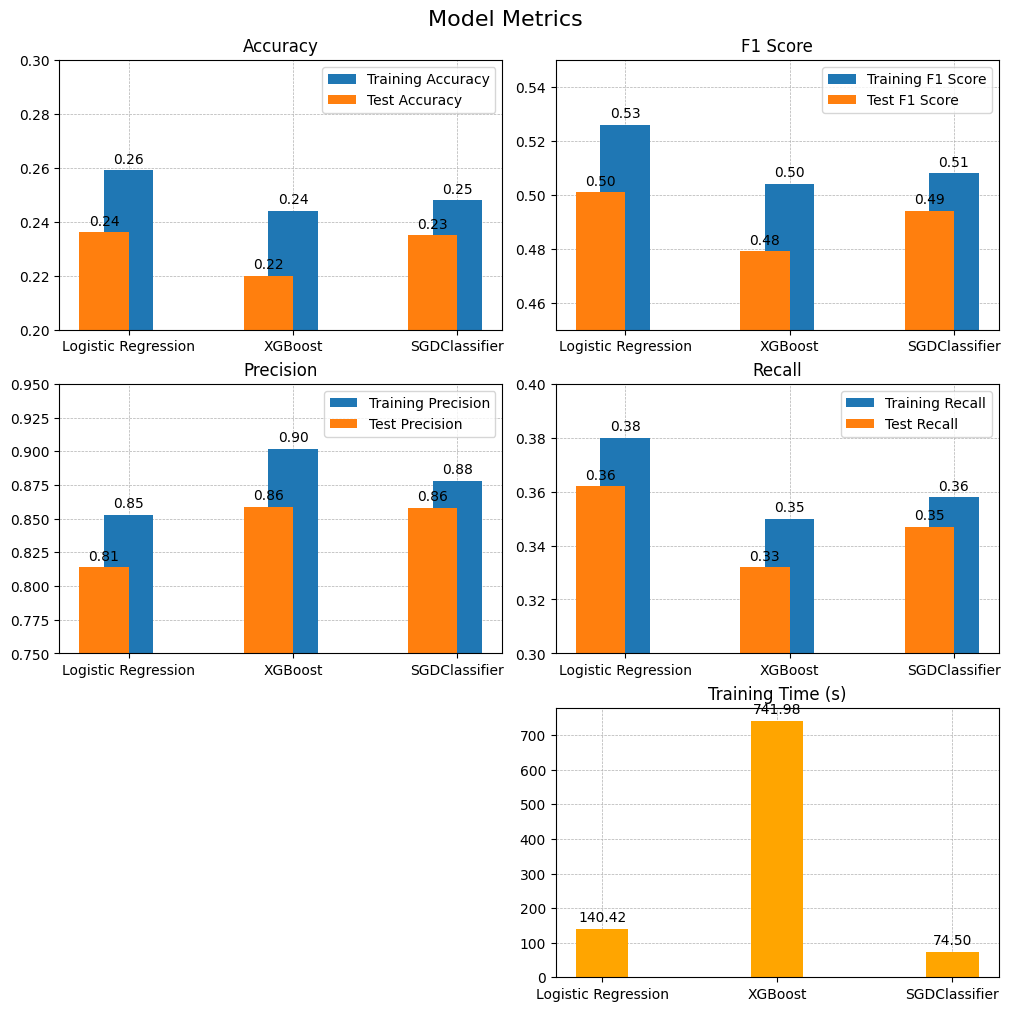

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for the models
model_data = {
    "Model": ["Logistic Regression", "XGBoost", "SGDClassifier"],
    "Training Accuracy": [0.259, 0.244, 0.248],
    "Test Accuracy": [0.236, 0.220, 0.235],
    "Training F1 Score": [0.526, 0.504, 0.508],
    "Test F1 Score": [0.501, 0.479, 0.494],
    "Training Precision": [0.853, 0.902, 0.878],
    "Test Precision": [0.814, 0.859, 0.858],
    "Training Recall": [0.380, 0.350, 0.358],
    "Test Recall": [0.362, 0.332, 0.347],
    "Training Time (s)": [140.42, 741.98, 74.5]  
}

# Create a DataFrame
metrics_data = pd.DataFrame(model_data)

# Set up the figure and axes
fig, axs = plt.subplots(3, 2, figsize=(10, 10), constrained_layout=True)
fig.suptitle('Model Metrics', fontsize=16)

# Function to add labels
def add_labels(ax, rects):
    """Add labels to the bars in a bar plot."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Plotting Training and Test Accuracy
width = 0.3
train_acc_rects = axs[0, 0].bar(metrics_data['Model'], metrics_data['Training Accuracy'], width=width, align='center', label='Training Accuracy')
test_acc_rects = axs[0, 0].bar(metrics_data['Model'], metrics_data['Test Accuracy'], width=-width, align='edge', label='Test Accuracy')
axs[0, 0].set_ylim(0.2, 0.3)  
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()
add_labels(axs[0, 0], train_acc_rects)
add_labels(axs[0, 0], test_acc_rects)

# Plotting Training and Test F1 Score
train_f1_rects = axs[0, 1].bar(metrics_data['Model'], metrics_data['Training F1 Score'], width=width, align='center', label='Training F1 Score')
test_f1_rects = axs[0, 1].bar(metrics_data['Model'], metrics_data['Test F1 Score'], width=-width, align='edge', label='Test F1 Score')
axs[0, 1].set_ylim(0.45, 0.55)  
axs[0, 1].set_title('F1 Score')
axs[0, 1].legend()
add_labels(axs[0, 1], train_f1_rects)
add_labels(axs[0, 1], test_f1_rects)

# Plotting Training and Test Precision
train_prec_rects = axs[1, 0].bar(metrics_data['Model'], metrics_data['Training Precision'], width=width, align='center', label='Training Precision')
test_prec_rects = axs[1, 0].bar(metrics_data['Model'], metrics_data['Test Precision'], width=-width, align='edge', label='Test Precision')
axs[1, 0].set_ylim(0.75, 0.95)  
axs[1, 0].set_title('Precision')
axs[1, 0].legend()
add_labels(axs[1, 0], train_prec_rects)
add_labels(axs[1, 0], test_prec_rects)

# Plotting Training and Test Recall
train_recall_rects = axs[1, 1].bar(metrics_data['Model'], metrics_data['Training Recall'], width=width, align='center', label='Training Recall')
test_recall_rects = axs[1, 1].bar(metrics_data['Model'], metrics_data['Test Recall'], width=-width, align='edge', label='Test Recall')
axs[1, 1].set_ylim(0.3, 0.4)  
axs[1, 1].set_title('Recall')
axs[1, 1].legend()
add_labels(axs[1, 1], train_recall_rects)
add_labels(axs[1, 1], test_recall_rects)

# Plotting Training Time in the middle of the second row
axs[2, 0].axis('off')  
time_rects = axs[2, 1].bar(metrics_data['Model'], metrics_data['Training Time (s)'], color='orange', width=width)
axs[2, 1].set_title('Training Time (s)')
add_labels(axs[2, 1], time_rects)

# Hide the empty subplot
axs[2, 0].axis('off')

# Add grid lines and make the plots more visually appealing
for ax in axs.flat:
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_axisbelow(True)

# Display the plot
plt.show()

## Analysis and Summary of Model Metrics Visualization

In this visualization, we compare the performance of three models: Logistic Regression, XGBoost, and SGDClassifier across various metrics including accuracy, F1 score, precision, recall, and training time. Here are the key observations:

1. **Training Time**: One of the most significant issues encountered was the training time, particularly for the XGBoost model. Increasing the parameters led to extremely long training times, making it less practical for certain applications.

2. **Accuracy**: Logistic Regression shows relatively balanced performance between training and test accuracy, but it is not the highest in either category. XGBoost and SGDClassifier demonstrate similar patterns with slight differences.

3. **F1 Score**: For those who prioritize the F1 score, Logistic Regression performs the best, indicating a balanced approach between precision and recall.

4. **Precision**: XGBoost stands out in terms of precision, suggesting it makes fewer false positive errors compared to the other models.

5. **Recall**: Logistic Regression and SGDClassifier perform similarly in recall, capturing most of the positive instances, whereas XGBoost lags slightly behind.

### Conclusion

When experimenting with different models, each model presents unique challenges and trade-offs. Depending on the specific requirements of your application, you can choose a model that aligns with your priorities:
- If F1 score is crucial, Logistic Regression is a strong choice.
- If precision is more important, XGBoost would be preferable despite its longer training times.
- For a balance of performance and shorter training times, SGDClassifier can be considered.

This analysis helps in making informed decisions based on the metrics that matter most to the specific use case. For our tag prediction project, the choice of model will depend on the specific goals. If our primary objective is to achieve a balance between precision and recall, then focusing on the F1 score and choosing Logistic Regression would be advantageous. On the other hand, if minimizing false positives is more critical, XGBoost, with its superior precision, would be the better option, even though it requires more computational resources. By understanding the specific needs of our project, we can select the most suitable model and continually fine-tune the hyperparameters to optimize performance.

